In [1]:
from pathlib import Path
import os
path = Path().absolute()

if path.name =="PCC":
    os.chdir(path.parent)

BASEDIR = Path().absolute()
BASEDIR

PosixPath('/home/taerim/PRIMNET-V2/code')

In [2]:
from utils.dataloader import get_dataset, Sampler
train_dataset,val_dataset,test_dataset,ext_dataset  = get_dataset(f"../dataset/FINGER.json", 1.0)

/home/taerim/PRIMNET-V2/code/utils/dataloader.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  motor_control = torch.tensor(data["motor_control"],dtype=torch.float32)
/home/taerim/PRIMNET-V2/code/utils/dataloader.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  position = torch.tensor(data["position"],dtype=torch.float32)


In [3]:
from utils.args import read_ARGS
configs = "PRIMNET/FINGER.py"


args = read_ARGS((BASEDIR/'configs'/configs).absolute())
args

ARGS(MODEL='PRIMNET', EVEN_JOINTS=True, WANDB=True, pname='PRIMNET_v2.1', runname='FINGER', DATASET='FINGER', TPOSE=((0, 0, 0.12),), LOAD_WEIGHTPATH=None, SAVE_PERIOD=1, TEST_PERIOD=1, EVEN_JOINT=True, p_offset_std=0.1, rpy_offset_std=0.01, axis_std=0.1, OUTPUT_NORMALIZE=False, seed=0, hdim=(16, 16), motor_embed_dim=4, lr=0.0015, lrd=0.95, wd=0.0, w_vec=0.001, epochs=500, focus_ratio=0.0, data_ratio=1.0, n_workers=2, batch_size=64, joint_seqs=('F', 'R', 'P', 'R', 'R', 'P', 'R'), marker_num=1, motor_dim=4)

In [4]:
args.section_number = 6

In [5]:
import torch

def eye_batch(batch_size, dim = 4):
    return torch.tile(torch.eye(dim),dims=(batch_size,1,1))

In [70]:
from utils.pyart import r2t,rpy2r,pr2t, t2p

batch_size = 16

phi    = torch.ones(batch_size, args.section_number)
theta  = torch.ones(batch_size, args.section_number)
radius = torch.ones(batch_size, args.section_number)



def forward_pcc(phi, theta, radius):
    device = phi.device

    batch_size = phi.shape[0]
    section_number = phi.shape[1]
    
    outs = []
    out = eye_batch(batch_size, dim=4).to(device)

    for section in range(section_number):
        phi_ = phi[:,section]
        theta_ = theta[:,section]
        radius_ = radius[:,section]
        
        phi_rpy = torch.stack([torch.zeros_like(phi_), torch.zeros_like(phi_), phi_], dim=1)
        assert phi_rpy.shape == (batch_size,3)
        T1 = r2t(rpy2r(phi_rpy))

        theta_rpy = torch.stack([ -theta_, torch.zeros_like(-theta_), torch.zeros_like(-theta_)],dim = 1)
        assert theta_rpy.shape == (batch_size,3)
        
        P = torch.zeros(batch_size, 3, 1).to(device)
        
        assert (radius_ * (1-torch.cos(theta_))).shape == (batch_size,)
        assert (radius_ * torch.sin(theta_)).shape == (batch_size,)
        
        P[:,1,0] = radius_ * (1-torch.cos(theta_))
        P[:,2,0] = radius_ * torch.sin(theta_)
        
        T2 = pr2t(P,rpy2r(theta_rpy))
        
        T = T1@T2
        out = out @ T
        outs.append(out)
    
    outs = torch.stack(outs, dim=1)
    return outs

forward_pcc(phi,theta,radius).shape

torch.Size([16, 6, 4, 4])

In [97]:
train_sampler = Sampler(args, train_dataset)
val_sampler   = Sampler(args, val_dataset)
test_sampler  = Sampler(args, test_dataset)
ext_sampler   = Sampler(args, ext_dataset)

PI = torch.pi


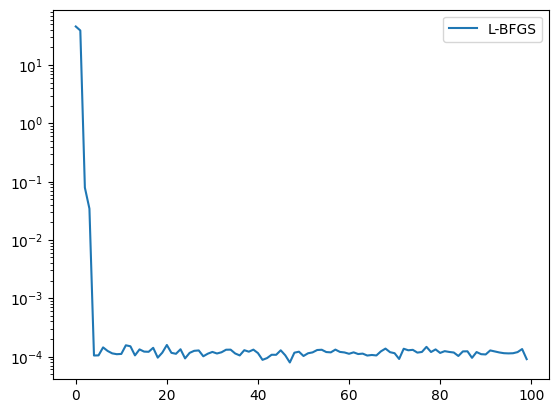

In [161]:
x = torch.tensor(.0); y = torch.tensor(.0); z = torch.tensor(.0);
L = torch.tensor(120.0)
R = torch.tensor(5.0)
d = torch.tensor(7.5)


LR = torch.tensor([L,R,d,x,y,z])
LR.requires_grad = True

from torch import optim
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt

optimizer = optim.LBFGS([LR],
                        history_size=10,
                        max_iter=4,
                        line_search_fn="strong_wolfe")



def p_loss_fn(x,y):
    loss =  F.smooth_l1_loss(x,y, reduction='none')
    loss = torch.mean(loss, dim=list(range(1,loss.ndim)))
    return loss

def closure():
    optimizer.zero_grad()
    pred_position = f(LR)
    position_loss =  p_loss_fn(pred_position, target_position[:,-1])
    
    total_loss = torch.mean(position_loss)
    total_loss.backward()
    return total_loss


h_lbfgs = []

for i in range(100):
    for batch in train_sampler:
        target_position = batch["position"]
        motor_control = batch["motor_control"]

        def f(LR):
            L,R,d,x,y,z = LR
            Lengths = torch.ones_like(motor_control)*L - motor_control/4096 * R * 2*PI
            l1,l3,l4,l2 = Lengths[:,0],Lengths[:,1],Lengths[:,2],Lengths[:,3]

            phi = torch.atan2((l4-l2),(l3-l1))
            theta = torch.sqrt((l3-l1)**2 + (l4-l2)**2) / (2*d)
            l = (l1+l2+l3+l4)/4
            radius = l/theta


            phi    = phi.reshape(-1,1)
            theta  = theta.reshape(-1,1)
            radius = radius.reshape(-1,1)

            phi.shape, theta.shape, radius.shape
            joint_se3 = forward_pcc(phi,theta, radius)

            EE_se3 = joint_se3[:,-1,:,:]
            pred_position = t2p(EE_se3)
            base_position = torch.stack([x,y,z]).reshape(-1,1)
            
            # assert pred_position.shape[1:] == base_position.shape
            # pred_position = pred_position + base_position
            return pred_position    

        
        optimizer.zero_grad()
    
    # pred_position = f(LR)
    # position_loss =  p_loss_fn(pred_position, target_position[:,-1])
    # objective = torch.mean(position_loss)
    
    
    objective = optimizer.step(closure)
    h_lbfgs.append(objective.item())
    
plt.semilogy(h_lbfgs, label='L-BFGS')
plt.legend()
plt.show()

In [155]:
LR

tensor([ 5.6770e+01,  3.9008e-02,  3.5042e+01, -9.6462e-04, -1.2759e-02,
        -5.6634e+01], requires_grad=True)

In [162]:
pred_position = f(LR)
position_loss =  p_loss_fn(pred_position, target_position[:,-1])
objective = torch.mean(position_loss)
objective

tensor(9.0048e-05, grad_fn=<MeanBackward0>)

In [163]:
pred_position = f(LR)
position_loss =  p_loss_fn(pred_position, target_position[:,-1])

total_loss = torch.mean(position_loss)
total_loss.requires_grad

True

In [164]:
for sampler in [val_sampler, test_sampler, ext_sampler]:

    batch = sampler.sample_all()
    motor_control = batch["motor_control"]
    target_position = batch["position"]


    with torch.no_grad():
        def f(LR):
            L,R,d,x,y,z = LR
            Lengths = torch.ones_like(motor_control)*L - motor_control/4096 * R * 2*PI
            l1,l3,l4,l2 = Lengths[:,0],Lengths[:,1],Lengths[:,2],Lengths[:,3]

            phi = torch.atan2((l4-l2),(l3-l1))
            theta = torch.sqrt((l3-l1)**2 + (l4-l2)**2) / (2*d)
            l = (l1+l2+l3+l4)/4
            radius = l/theta


            phi    = phi.reshape(-1,1)
            theta  = theta.reshape(-1,1)
            radius = radius.reshape(-1,1)

            phi.shape, theta.shape, radius.shape
            joint_se3 = forward_pcc(phi,theta, radius)

            EE_se3 = joint_se3[:,-1,:,:]
            pred_position = t2p(EE_se3)
            base_position = torch.stack([x,y,z]).reshape(-1,1)
            pred_position = pred_position + base_position
            return pred_position   

        pred_position = f(LR)
        position_loss =  p_loss_fn(pred_position, target_position[:,-1])

        total_loss = torch.mean(position_loss)
        print(total_loss)

tensor(0.0001)
tensor(0.0001)
tensor(0.0003)
